## Índice Nacional de Precios Productor excluyendo petróleo


In [9]:
import requests
import pandas as pd
import plotly.graph_objects as go
from statsmodels.tsa.statespace.sarimax import SARIMAX
 
# --- Parámetros ---
token     = "45b0d369-41fd-467a-b7c9-6b862cf3056d"      # <— reemplaza
indicator = "910493"              # INPC general 444558 O 910424
geo       = "00000"               # Nacional (5 ceros)
fuente    = "BIE"                 # Banco de Información Económica (prueba BISE si hiciera falta)
url = (
    "https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/"
    f"INDICATOR/{indicator}/es/{geo}/false/{fuente}/2.0/{token}?type=json"
)
 
# --- Llamada API con manejo de errores legible ---
resp = requests.get(url)
if resp.status_code != 200:
    raise SystemExit(f"INEGI {resp.status_code}: {resp.text[:400]}")
 
j = resp.json()

In [10]:
# --- Graficar serie de tiempo (a partir del JSON `j`) ---

import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "browser"   # abre en navegador por defecto


# 1) Convertir JSON a DataFrame mensual
series_key = "Series" if "Series" in j else ("series" if "series" in j else None)
obs = j[series_key][0]["OBSERVATIONS"]

df = (
    pd.DataFrame(obs)[["TIME_PERIOD", "OBS_VALUE"]]
    .rename(columns={"TIME_PERIOD": "fecha", "OBS_VALUE": "valor"})
)
df["fecha"] = pd.to_datetime(df["fecha"], errors="coerce")
df["valor"] = pd.to_numeric(df["valor"], errors="coerce")
df = df.dropna().sort_values("fecha").set_index("fecha")
# asegurar frecuencia mensual (por si viniera irregular)
df = df.asfreq("MS") if df.index.inferred_freq is None else df
df = df.resample("MS").last()

# 2) Gráfica interactiva con Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df.index, y=df["valor"],
    mode="lines",
    name="Serie observada"
))
fig.update_layout(
    title=f"Serie de tiempo — Indicador {indicator}",
    xaxis_title="Fecha",
    yaxis_title="Índice",
    hovermode="x unified",
    template="plotly_white"
)
fig.show()

/var/folders/fd/q5kbvbvd00b4rdf_lfzx0j3m0000gp/T/ipykernel_71004/661477536.py:17: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [11]:
import plotly.express as px

# Filtrar desde 2015
df_2015 = df[df.index >= "2015-01-01"].copy()

# Crear columnas auxiliares para separar por año y mes
df_2015["Año"] = df_2015.index.year
df_2015["Mes"] = df_2015.index.month

# Gráfica de líneas: cada año una curva (mes en eje X)
fig = px.line(
    df_2015,
    x="Mes", y="valor",
    color="Año",
    markers=True,
    title="Comportamiento del INPC por año (2015 en adelante)"
)

fig.update_layout(
    xaxis=dict(tickmode="array", tickvals=list(range(1, 13))),
    yaxis_title="INPC",
    xaxis_title="Mes",
    legend_title="Año",
    template="plotly_white"
)

fig.show()


In [12]:
# --- Paso 2 (alternativo): Descomposición STL para diagnosticar tendencia/estacionalidad ---

import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import STL
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.stattools import adfuller, kpss

# y: serie mensual lista (asegura frecuencia mensual y orden cronológico)
y = df["valor"].copy().sort_index()
# Normaliza a frecuencia mensual por si hiciera falta
y = y.asfreq("MS")
# (opcional) si hay pocos NaN intermensuales, puedes imputar suavemente:
# y = y.interpolate(limit_direction="both")

# Periodicidad estacional: mensual -> 12
stl = STL(y, period=12, robust=True)
res = stl.fit()

# Serie desestacionalizada (útil para justificar D=0/1)
sa = y - res.seasonal  # seasonally adjusted

# --- Gráfica interactiva con subplots ---
fig = make_subplots(
    rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.04,
    subplot_titles=("Observado", "Tendencia (Trend)", "Estacionalidad (Seasonal)", "Residuo (Remainder)")
)

fig.add_trace(go.Scatter(x=y.index,  y=y.values,            name="Observado",   mode="lines"), row=1, col=1)
fig.add_trace(go.Scatter(x=y.index,  y=res.trend.values,    name="Tendencia",   mode="lines"), row=2, col=1)
fig.add_trace(go.Scatter(x=y.index,  y=res.seasonal.values, name="Estacional",  mode="lines"), row=3, col=1)
fig.add_trace(go.Scatter(x=y.index,  y=res.resid.values,    name="Residuo",     mode="lines"), row=4, col=1)

fig.update_layout(
    title="Descomposición STL (periodo=12, robust=True)",
    hovermode="x unified",
    template="plotly_white",
    height=900,
    showlegend=False
)
fig.update_xaxes(title_text="Fecha", row=4, col=1)
fig.update_yaxes(title_text="Índice", row=1, col=1)

fig.show()



In [13]:

# Suponiendo que y es un pandas.Series con índice datetime
y_2018 = y[y.index >= "2018-01-01"]

# Prueba ADF (Augmented Dickey-Fuller)
adf_result = adfuller(y_2018)
print("=== Prueba ADF (desde 2018) ===")
print(f"Estadístico: {adf_result[0]:.4f}")
print(f"p-valor: {adf_result[1]:.4f}")
print("Hipótesis nula: La serie NO es estacionaria")

# Prueba KPSS
kpss_result = kpss(y_2018, regression="c", nlags="auto")
print("\n=== Prueba KPSS (desde 2018) ===")
print(f"Estadístico: {kpss_result[0]:.4f}")
print(f"p-valor: {kpss_result[1]:.4f}")
print("Hipótesis nula: La serie SÍ es estacionaria")


=== Prueba ADF (desde 2018) ===
Estadístico: -0.5484
p-valor: 0.8822
Hipótesis nula: La serie NO es estacionaria

=== Prueba KPSS (desde 2018) ===
Estadístico: 1.5786
p-valor: 0.0100
Hipótesis nula: La serie SÍ es estacionaria


/var/folders/fd/q5kbvbvd00b4rdf_lfzx0j3m0000gp/T/ipykernel_71004/3675314581.py:12: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




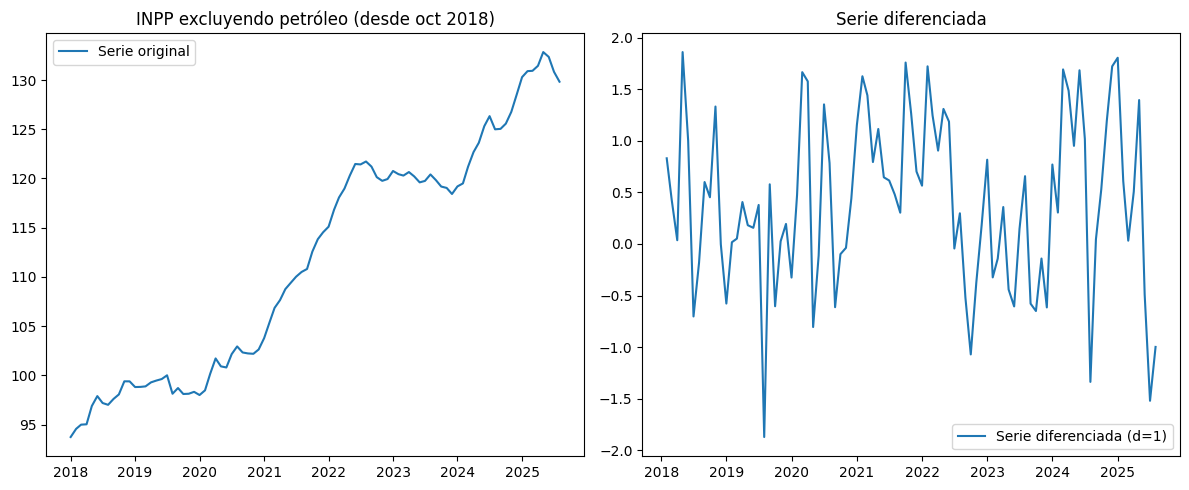

=== Prueba ADF (serie diferenciada) ===
Estadístico: -6.0498
p-valor: 0.0000
Hipótesis nula: La serie NO es estacionaria

=== Prueba KPSS (serie diferenciada) ===
Estadístico: 0.0838
p-valor: 0.1000
Hipótesis nula: La serie SÍ es estacionaria


/var/folders/fd/q5kbvbvd00b4rdf_lfzx0j3m0000gp/T/ipykernel_71004/746240279.py:35: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




In [14]:
# --- Paso 3: Diferenciación y nueva prueba de estacionariedad ---

from statsmodels.tsa.stattools import adfuller, kpss
import matplotlib.pyplot as plt

# 1) Filtrar desde octubre 2018
y = df["valor"].copy().sort_index()
y = y[y.index >= "2018-01-01"]

# 2) Diferenciación de primer orden
y_diff = y.diff().dropna()

# 3) Graficar comparación antes/después
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(y, label="Serie original")
plt.title("INPP excluyendo petróleo (desde oct 2018)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(y_diff, label="Serie diferenciada (d=1)")
plt.title("Serie diferenciada")
plt.legend()
plt.tight_layout()
plt.show()

# 4) Prueba ADF
adf_result = adfuller(y_diff)
print("=== Prueba ADF (serie diferenciada) ===")
print(f"Estadístico: {adf_result[0]:.4f}")
print(f"p-valor: {adf_result[1]:.4f}")
print("Hipótesis nula: La serie NO es estacionaria")

# 5) Prueba KPSS
kpss_result = kpss(y_diff, regression="c", nlags="auto")
print("\n=== Prueba KPSS (serie diferenciada) ===")
print(f"Estadístico: {kpss_result[0]:.4f}")
print(f"p-valor: {kpss_result[1]:.4f}")
print("Hipótesis nula: La serie SÍ es estacionaria")


Despues de la diferenciacion se obtiene de ambas pruebas la conclusion de que ya son estacionarias. 

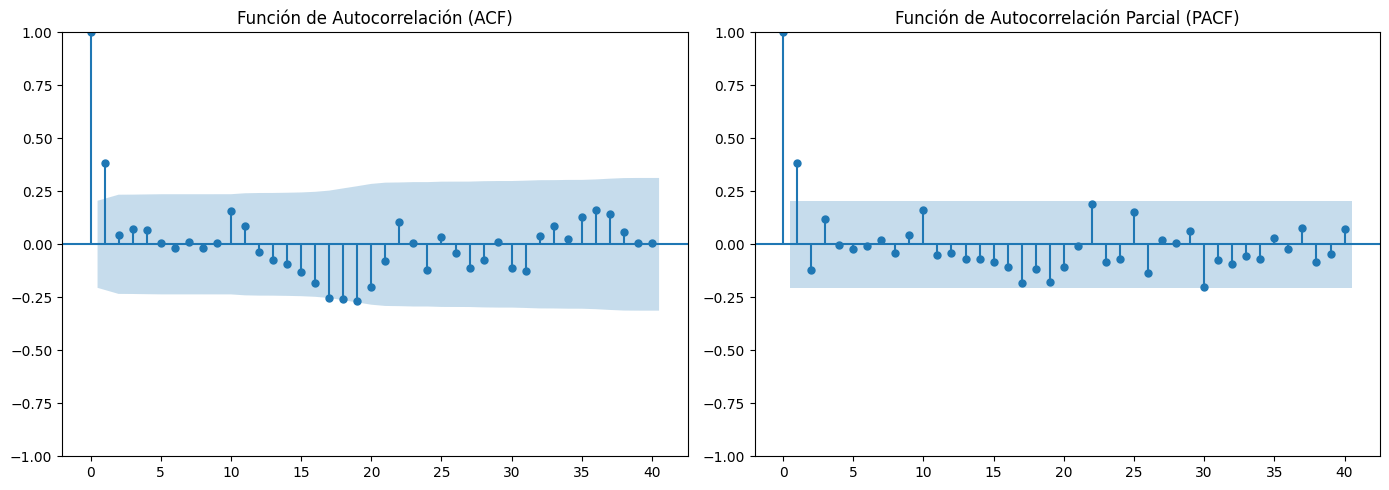

In [15]:
# --- Paso 4: ACF y PACF para identificar p, q y P, Q ---

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Trabajamos con la serie diferenciada (ya estacionaria)
y_diff = y.diff().dropna()

fig, axes = plt.subplots(1, 2, figsize=(14,5))

# ACF -> ayuda a identificar q y Q
plot_acf(y_diff, lags=40, ax=axes[0])
axes[0].set_title("Función de Autocorrelación (ACF)")

# PACF -> ayuda a identificar p y P
plot_pacf(y_diff, lags=40, ax=axes[1])
axes[1].set_title("Función de Autocorrelación Parcial (PACF)")

plt.tight_layout()
plt.show()


📈 Interpretación de la ACF (Autocorrelación)

La ACF cae rápido después del rezago 1, con un pico significativo al rezago 1.

Esto sugiere la presencia de un componente de media móvil (q=1).

No se observa un patrón estacional muy claro en múltiplos de 12 (aunque habría que confirmarlo con la serie completa, no solo con la diferenciada).

📉 Interpretación de la PACF (Autocorrelación parcial)

La PACF también muestra un pico significativo en el rezago 1 y luego cae dentro de las bandas.

Esto indica un componente autorregresivo simple (p=1).

Nuevamente, no se ven rezagos largos dominantes que obliguen a meter un AR estacional evidente.

🛠️ Selección inicial de parámetros

Con estas dos gráficas y sabiendo que ya aplicaste una diferenciación regular (d=1), la primera hipótesis de modelo sería:

(p,d,q) = (1,1,1) como punto de partida.

In [16]:
import pandas as pd
import plotly.express as px

y = df["valor"].copy().asfreq("MS")

# Subseries: línea por año sobre el eje de meses
tmp = y.to_frame("valor").reset_index()
tmp["Año"] = tmp["fecha"].dt.year
tmp["Mes"] = tmp["fecha"].dt.month

fig1 = px.line(tmp, x="Mes", y="valor", color="Año",
               title="Subseries estacionales (cada año sobre meses 1–12)")
fig1.update_layout(template="plotly_white", xaxis=dict(tickvals=list(range(1,13))))
fig1.show()

# Boxplot por mes: variabilidad estacional
fig2 = px.box(tmp, x="Mes", y="valor",
              title="Boxplot por mes (fuerza de la estacionalidad)")
fig2.update_layout(template="plotly_white", xaxis=dict(tickvals=list(range(1,13))))
fig2.show()


In [17]:
import plotly.express as px

pivot = tmp.pivot_table(index="Año", columns="Mes", values="valor")
fig3 = px.imshow(pivot, aspect="auto", origin="lower",
                 title="Heatmap Año–Mes del índice")
fig3.update_layout(template="plotly_white")
fig3.show()


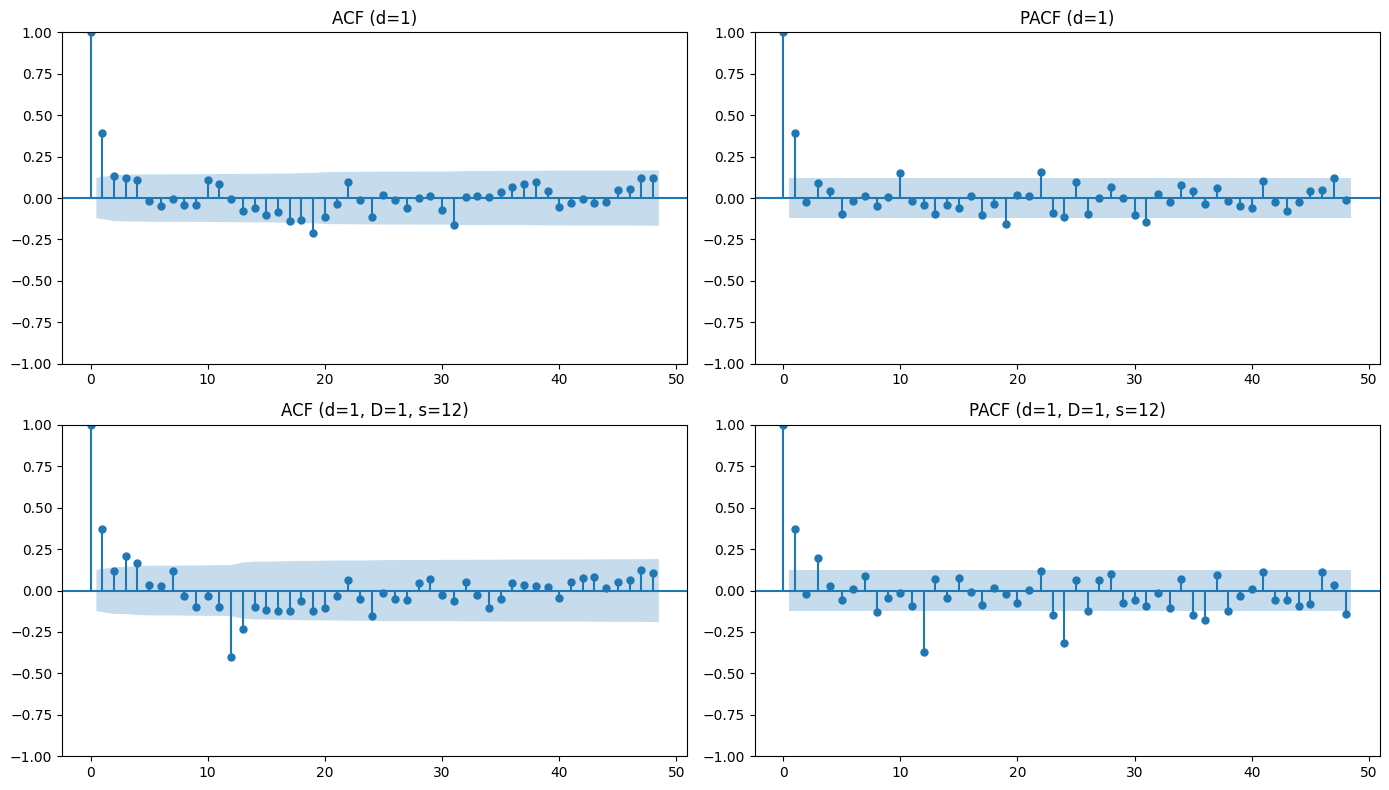

In [18]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

y = df["valor"].copy().asfreq("MS")
y_d1 = y.diff().dropna()              # ya confirmaste que d=1 funciona
s = 12
y_D1 = y_d1.diff(s).dropna()          # candidata D=1

fig, axes = plt.subplots(2, 2, figsize=(14,8))
plot_acf(y_d1, lags=48, ax=axes[0,0]); axes[0,0].set_title("ACF (d=1)")
plot_pacf(y_d1, lags=48, ax=axes[0,1]); axes[0,1].set_title("PACF (d=1)")

plot_acf(y_D1, lags=48, ax=axes[1,0]); axes[1,0].set_title("ACF (d=1, D=1, s=12)")
plot_pacf(y_D1, lags=48, ax=axes[1,1]); axes[1,1].set_title("PACF (d=1, D=1, s=12)")
plt.tight_layout(); plt.show()


In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

def fit_sarima(y, order, seasonal_order):
    m = SARIMAX(y, order=order, seasonal_order=seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False)
    return m.fit(disp=False)

y_full = df["valor"].asfreq("MS").dropna()

cand = [
    ((1,1,1), (0,0,0,12)),
    ((1,1,1), (0,1,0,12)),
    ((1,1,1), (1,1,0,12)),
    ((1,1,1), (0,1,1,12)),
    ((1,1,1), (1,1,1,12)),
]
results = []
for o, so in cand:
    try:
        res = fit_sarima(y_full, o, so)
        results.append((o, so, res.aic))
    except Exception:
        results.append((o, so, np.inf))

for o, so, aic in sorted(results, key=lambda x: x[2]):
    print(f"order={o} seasonal_order={so}  AIC={aic:.1f}")


order=(1, 1, 1) seasonal_order=(0, 1, 1, 12)  AIC=431.0
order=(1, 1, 1) seasonal_order=(1, 1, 1, 12)  AIC=439.0
order=(1, 1, 1) seasonal_order=(0, 0, 0, 12)  AIC=455.6
order=(1, 1, 1) seasonal_order=(1, 1, 0, 12)  AIC=526.2
order=(1, 1, 1) seasonal_order=(0, 1, 0, 12)  AIC=586.9


(P, D, Q, s) = (0, 1, 1, 12)

1) Boxplot por mes

Muestra diferencias sistemáticas por mes (las medianas/dispersiones no son idénticas).

Esto respalda que hay estacionalidad anual ⇒ s = 12.

La estacionalidad no es extrema, pero es persistente, suficiente para modelarla.

2) Heatmap Año–Mes

Se observa un gradiente anual (tendencia) y oscilaciones intra-año relativamente estables.

De nuevo, indica un componente estacional de 12 meses que conviene diferenciar para estabilizar niveles ⇒ D = 1.

3) Correlogramas con d=1 (arriba)

ACF (d=1): aparece un pico en el rezago 12 (y armónicos suaves), característico de MA estacional.

PACF (d=1): no muestra un corte claro en 12 (no domina un AR estacional marcado).

Lectura: la estacionalidad remanente se comporta tipo MA ⇒ candidato Q = 1, P = 0.

4) Correlogramas con d=1, D=1, s=12 (abajo)

Tras aplicar D=1, el pico en 12 se atenúa notablemente en ACF/PACF.

Esto confirma que el diferenciado estacional es adecuado; además no se exige un AR estacional adicional (P=0 suele bastar); MA estacional (Q=1) conserva el patrón residual que quedaba.

5) Comparación de modelos (AIC)

(1,1,1) × (0,1,1,12) → AIC = 431.0 (mejor)

(1,1,1) × (1,1,1,12) → AIC = 439.0

(1,1,1) × (0,0,0,12) → AIC = 455.6

(1,1,1) × (1,1,0,12) → AIC = 526.2

(1,1,1) × (0,1,0,12) → AIC = 586.9
Conclusión: los modelos con D=1 ganan ampliamente; el mejor agrega MA estacional (Q=1) y no AR estacional (P=0). Añadir P=1 empeora (AIC ↑).

In [21]:
# --- División en train/test con horizonte de 12 meses ---

# 1) Serie desde enero 2018
y = df["valor"].copy().sort_index()
y = y[y.index >= "2018-01-01"]

# 2) Definir horizonte de prueba (últimos 12 meses)
horizon = 12

# 3) División
y_train = y.iloc[:-horizon]
y_test  = y.iloc[-horizon:]

print("Entrenamiento:", y_train.index.min().strftime("%Y-%m"), "→", y_train.index.max().strftime("%Y-%m"))
print("Prueba:", y_test.index.min().strftime("%Y-%m"), "→", y_test.index.max().strftime("%Y-%m"))
print("\nTamaño train:", len(y_train), " | Tamaño test:", len(y_test))


Entrenamiento: 2018-01 → 2024-08
Prueba: 2024-09 → 2025-08

Tamaño train: 80  | Tamaño test: 12


In [22]:
# --- SARIMA(1,1,1) x (0,1,1,12): entrenar con y_train y predecir y_test ---
from statsmodels.tsa.statespace.sarimax import SARIMAX
import plotly.graph_objects as go
import numpy as np

# Asegura que y, y_train, y_test existen (del chunk anterior)
# y = df["valor"].copy().sort_index()
# y_train = y.iloc[:-12]; y_test = y.iloc[-12:]

order = (1, 1, 1)
seasonal_order = (0, 1, 1, 12)

# Entrenamiento
model = SARIMAX(
    y_train,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
res = model.fit(disp=False)

# Pronóstico del mismo tamaño que el test
steps = len(y_test)
fc = res.get_forecast(steps=steps)
fc_mean = fc.predicted_mean
fc_ci   = fc.conf_int(alpha=0.05)  # 95%

# Alinear índices por si acaso
fc_mean.index = y_test.index
fc_ci.index   = y_test.index

# MAPE
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero = y_true != 0
    return float(np.mean(np.abs((y_true[nonzero]-y_pred[nonzero]) / y_true[nonzero])) * 100)

mape_val = mape(y_test.values, fc_mean.values)

# --- Gráfica interactiva ---
fig = go.Figure()

# Observado (train)
fig.add_trace(go.Scatter(
    x=y_train.index, y=y_train.values,
    mode="lines", name="Observado (train)"
))

# Observado (test)
fig.add_trace(go.Scatter(
    x=y_test.index, y=y_test.values,
    mode="lines", name="Observado (test)"
))

# Pronóstico
fig.add_trace(go.Scatter(
    x=fc_mean.index, y=fc_mean.values,
    mode="lines", name="Pronóstico 12 meses", line=dict(dash="dash")
))

# Bandas de confianza
fig.add_trace(go.Scatter(
    x=fc_ci.index, y=fc_ci.iloc[:,0],
    mode="lines", line=dict(width=0), showlegend=False
))
fig.add_trace(go.Scatter(
    x=fc_ci.index, y=fc_ci.iloc[:,1],
    mode="lines", line=dict(width=0), fill="tonexty",
    name="IC 95%"
))

fig.update_layout(
    title=f"SARIMA{order}×{seasonal_order} — Pronóstico vs Real | MAPE(Test)={mape_val:.2f}%",
    xaxis_title="Fecha", yaxis_title="Índice",
    hovermode="x unified", template="plotly_white",
    legend_title="Series"
)

fig.show()

print(f"MAPE sobre el conjunto de prueba (últimos {steps} meses): {mape_val:.2f}%")


MAPE sobre el conjunto de prueba (últimos 12 meses): 2.32%


Con MAPE=2.32%, tu exactitud ≈ 97.7%, lo cual es mucho mejor que 70%. ✅